# 랜덤 포레스트

배깅은 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘이다. 배깅의 대표적인 알고리즘이 랜덤 포레스트다.

<br/>

#### 랜덤 포레스트 장점
* 결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있음
* 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있음
* 다양한 영역에서 높은 예측 성능을 나타냄

#### 랜덤 포레스트 단점
* 하이퍼 파라미터가 많아 튜닝을 위한 시간이 많이 소요됨

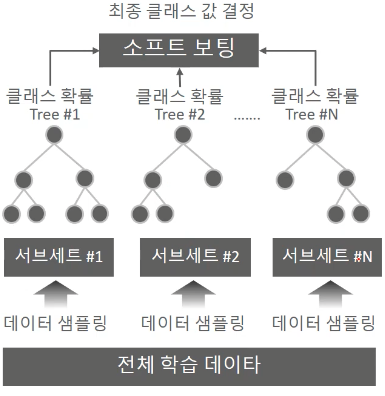



랜덤 포레스트는 개별적인 분류기의 기반 알고리즘은 결정 트리이지만 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트이다. 이렇게 여러 개의 데이터 세트를 중첩되게 분리하는 것을 **부트스트래핑(bootstrapping)** 분할 방식이라고 한다.

랜덤 포레스트의 서브세트(Subset) 데이터는 이러한 부트스트래핑으로 데이터가 임의로 만들어진다. 서브세트의 데이터 건수는 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩되어 만들어진다. 

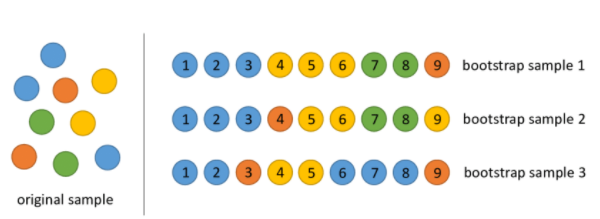

In [1]:
# 사이킷런의 RandomForestClassifier 클래스 이용
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [3]:
def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action을 ㅗ부여
    y_train = pd.read_csv('./y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


# 랜덤 포레스트 하이퍼 파라미터 및 튜닝

랜덤 포레스트는 트리 기반의 하이퍼 파라미터에 배깅, 부스팅, 학습, 정규화 등을 위한 하이퍼 파라미터가지 추가되어 튜닝할 파라미터가 많다.

* n_estimators : 랜덤 포레스트에서 결정 트리 개수를 지정. Default=10. 많이 설정할수록 좋은 성능 기대할 수 있지만 계속 증가한다고 성능이 무조건 향상되는 것은 아니다. 또한 늘릴수록 오래 걸림.

* max_features : 최적 분할을 위해 고려할 최대 feature 개수. Default='auto'(결정 트리에서는 none). 'sqrt' 또는 'auto는 전체 피처 중 (피처 개수)^2 만큼 선정. 'log'는 전체 피처 중 log2(전체 피처 개수)만큼 선정

* max_depth : 트리 최대 깊이. default=None(완벽하게 클래스 값이 결정될 때까지 분할 또는 min_samples_split보다 작아질 때까지 분할) 깊이가 깊어지면 과적합될 수 있으므로 제어 필요

* max_leaf_nodes : 리프 노드 최대 개수

* min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터 수 -> 과적합을 제어하는데 사용. Default=2 -> 작게 설정할수록 분할 노드가 많아져 과적합 가능성 증가

* min_samples_leaf : 리프 노드가 되기 위해 필요한 최소한의 샘플 데이터 수. min_samples_split과 함께 과적합 제어 용도. 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작아질 수 있으므로 작게 설정 필요.

In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1) # n_jobs=-1 파라미터 추가 시 모든 CPU 코어를 이용해 학습
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1)  # cv : 교차 검증을 위해 분할되는 폴드 수.
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9222


In [6]:
# 위에 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=8, min_samples_split=8, random_state=0, n_jobs=-1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9230


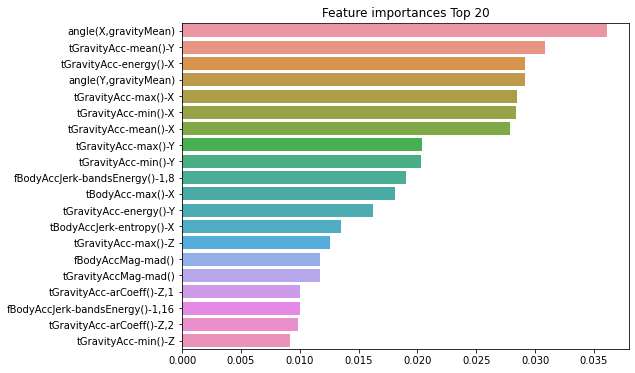

In [7]:
# 막대그래프를 사용하여 features_importances_로 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()